<a href="https://colab.research.google.com/github/bingjeff/colony/blob/main/image_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
"""Simple tool for class labeling of images in Jupyter notebooks.
Classes:
    ImageClassLabeler
"""
import pathlib
import ipywidgets

from IPython import display

# from IPython.display import Image, clear_output, display
# from ipywidgets import Button, HBox, Output, Layout


class LabelingTool:
    """A tool to be used for image classification labeling.
    Needs to run in a jupyter notebook to display ipywidgets.
    Attributes:
        classes: A list of image classes to be assigned during labeling.
        path: The path to the directory that contains the images.
        images: A list of the image files in the directory.
        current: Pointer to the current position of the tool.
        labels: Dictionary with assigned labels {'filename': 'label'}.
    """

    def __init__(
        self,
        classes: list,
        path: str,
        images: list[str] | None = None,
    ) -> None:
        """Construct all necessary attributes for the LabelingTool object.
        Args:
            classes: List of candidate labels (typically strings).
            path: Path to the directory containing the images to be labeled.
        """
        # store list of available class labels
        self.classes = classes

        # store path and list of images in path
        self.path = pathlib.Path(path)
        self.images = [f.name for f in self.path.glob("*.jpg")]

        # set up empty dict for labels and initial position
        self.labels = {}
        self.position = 0

    def _next(self, *args) -> None:
        """Select the next image and updates the displays.
        Args:
            *args: Variable length argument list, allows to pass Button object.
        """
        # update position
        self.position += 1
        if self.position == len(self.images):
            self.position = 0

        # refresh display
        image = display.Image(self.path / self.images[self.position])
        with self.frame:
            display.clear_output(wait=True)
            display(image)

    def _go_back(self, *args) -> None:
        """Select the previous image and updates the displays.
        Do not do anything if it is the first image.
        Args:
            *args: Variable length argument list, allows to pass Button object.
        """
        # update position
        self.position -= 1
        if self.position == -1:
            self.position = len(self.images) - 1

        # refresh display
        image = display.Image(self.path / self.images[self.position])
        with self.frame:
            display.clear_output(wait=True)
            display.display(image)

    def _select_label(self, button: ipywidgets.Button) -> None:
        """Attach a label to the current image and stores it.
        Link the label from a given button to the current image and store it
        in the labels dictionary and in the current working directory as .json.
        Args:
            button (ipywidgets.Button): a button supplying the label to be
                associated with the current image
        """
        # store label
        current_image = self.images[self.position]
        self.labels[current_image] = button.description

        # move on
        self._next()

    def start(self) -> None:
        """Start the labeling procedure.
        Load the first image to label and set up the user interface.
        """
        # image frame
        image = display.Image(self.path / self.images[self.position])
        self.frame = ipywidgets.Output(layout=ipywidgets.Layout(height="300px", max_width="300px"))
        with self.frame:
            display(image)

        # navigation buttons
        backward_button = ipywidgets.Button(description="< go back")
        backward_button.on_click(self._go_back)
        forward_button = ipywidgets.Button(description="next >")
        forward_button.on_click(self._next)
        self.navigation_buttons = [backward_button, forward_button]

        # class label buttons
        self.class_buttons = []
        for label in self.classes:
            label_button = ipywidgets.Button(description=label)
            label_button.on_click(self._select_label)
            self.class_buttons.append(label_button)

        # display contents
        display(self.frame)
        display(ipywidgets.HBox(self.navigation_buttons))
        display(ipywidgets.HBox(self.class_buttons))

In [5]:
from google.colab import output
output.enable_custom_widget_manager()

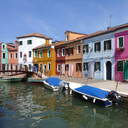

In [10]:
img = display.Image(IMAGE)
display.display(img)

In [6]:
box_widget = BoxAnnotator(options=["eye", "mouth", "nose", "cheek"])
DATA_DIR = 'https://github.com/hhoppe/data/raw/main/'  # Or any local path.
IMAGE = DATA_DIR + 'image.png'
box_widget.display(IMAGE)


BoxAnnotator(children=(Event(source=BoxAnnotator(children=(...), layout=Layout(width='700px')), throttle_or_de…